# Libraries

In [60]:
import warnings
warnings.filterwarnings('ignore') 

import pandas as pd 
import numpy as np 
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt 
import seaborn as sns  
import plotly.express as px
from tqdm.auto import tqdm  

import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
from collections import Counter 
from string import punctuation 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from gensim.models import Word2Vec

from keras.utils import plot_model

import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM , Dropout
from tensorflow.keras.optimizers import Adam

lemma = WordNetLemmatizer()
lb = LabelEncoder()

# Data

In [2]:
data = pd.read_csv(r"C:\Users\user\Documents\Datasets\Sentiment analysis\dataset.csv")
data

Text Language      Label
0       @Charlie_Corley @Kristine1G @amyklobuchar @Sty...       en  litigious
1       #BadBunny: Como dos gotas de agua: Joven se di...       es   negative
2       https://t.co/YJNiO0p1JV Flagstar Bank disclose...       en  litigious
3       Rwanda is set to host the headquarters of Unit...       en   positive
4       OOPS. I typed her name incorrectly (today’s br...       en  litigious
...                                                   ...      ...        ...
937849            @Juice_Lemons in the dark. it’s so good       en   positive
937850  8.SSR &amp; Disha Salian case should be solved...       en   negative
937851  *ACCIDENT:  Damage Only* - Raleigh Fire Depart...       en   negative
937852  @reblavoie So happy for her! She’s been incred...       en   positive
937853                         I'm lost and I'm found but       en   negative

[937854 rows x 3 columns]

In [3]:
data.columns

Index(['Text', 'Language', 'Label'], dtype='object')

In [4]:
data.drop(columns=['Language'], inplace = True)
data = data.iloc[0:200000]

In [5]:
data['Label'].value_counts()
data['tweet_len'] = [len(text.split()) for text in data.Text] 

In [6]:
data = data[~(data['tweet_len'] < 5) & ~(data['tweet_len'] > 60)]

## Data Cleaning

In [7]:
def cleaning(txt) : 
    txt = txt.lower() 
    
    txt = re.sub("<br /><br />" , " " , txt) # replace line breaks
    
    txt = re.sub(r"(.)\1\1+" , r"\1\1" , txt)  # Replace 3 or more consecutive letters by 2 letter
    
    # replace all emojis
    txt = re.sub(r'<3', '<heart>' , txt) 
    txt = re.sub(r"[8:=;]['`\-]?[)d]+" , '<smile>' , txt)
    txt = re.sub(r"[8:=;]['`\-]?\(+" , '<sadface>' , txt) 
    txt = re.sub(r"[8:=;]['`\-]?[\/|l*]" , '<neutralface>' , txt) 
    txt = re.sub(r"[8:=;]['`\-]?p+" , '<lolface>' , txt)
    
    txt = re.sub(r"[^a-z0-9<>]" , ' ' , txt) # # Remove non-alphanumeric and symbols
    
    # Adding space on either side of '/' to seperate words (After replacing URLS). 
    txt = re.sub(r'/' , ' / ' , txt)
    
    txt = re.sub('<.*?>', '', txt) # HTML tags
    txt = re.sub(r'\d+', '', txt) # numbers
    txt = re.sub(r'[^\w\s]', '', txt) # special characters
    txt = re.sub(r'http\S+', '', txt) # URLs or web links
    txt = re.sub(r'@\S+', '', txt) # mentions
    txt = re.sub(r'#\S+', '', txt) # hashtags
    
    return txt

In [8]:
data['Text'] = data['Text'].apply(cleaning)
print(f'Total number of samples: {len(data)}')
data.drop_duplicates(inplace = True)
data.dropna(inplace = True)
print(f'Total number of samples after removal: {len(data)}')

Total number of samples: 191504
Total number of samples after removal: 191083


# EDA

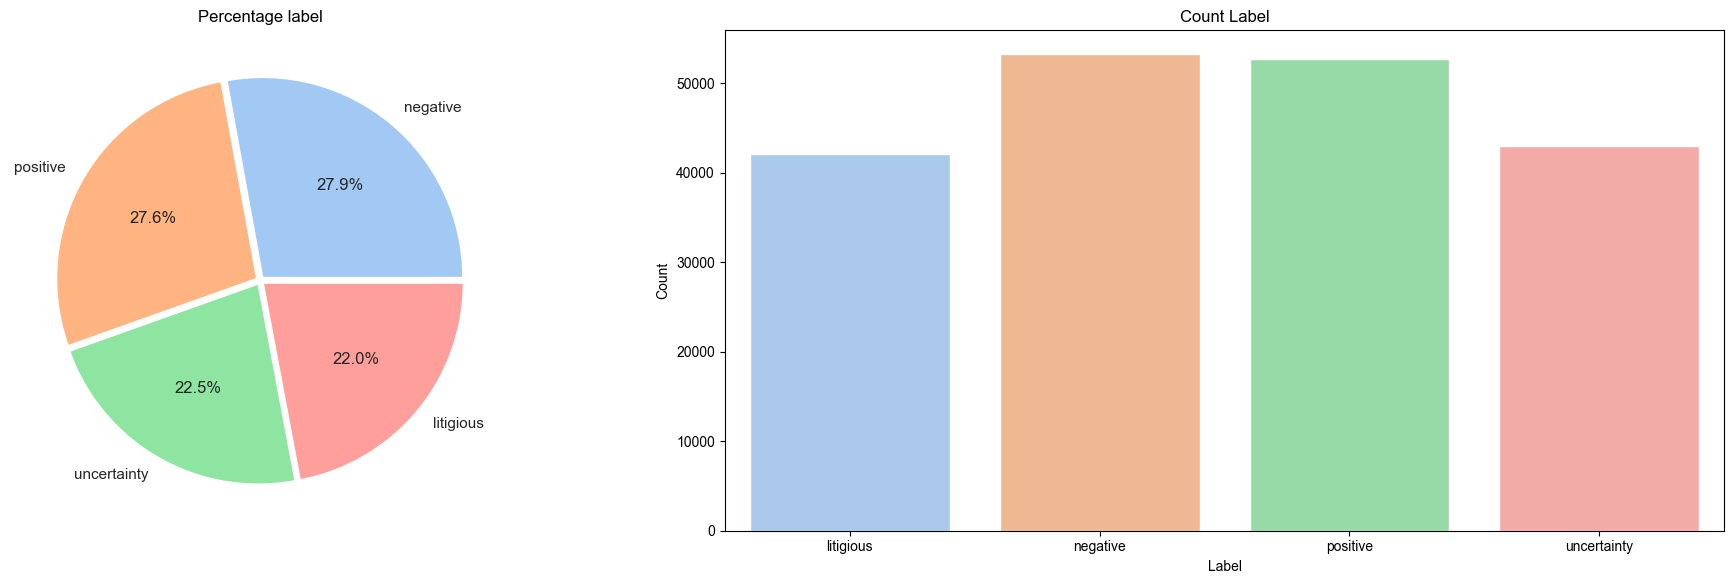

In [9]:
label_count = data['Label'].value_counts()
fig, ax = plt.subplots(1, 2, figsize = (20, 6))

sns.set_theme(style = 'darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02] * len(label_count)

ax[0].pie(label_count.values, labels = label_count.index, autopct = '%1.1f%%', colors = color, explode = explode) 
ax[0].set_title('Percentage label')

sns.countplot(x = data['Label'], ax = ax[1], palette='pastel')
ax[1].set_title('Count Label')
ax[1].set_xlabel('Label')
ax[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [10]:
px.histogram(data, x = 'tweet_len', height = 700, title = 'Tweets Length Distribution', marginal = 'box')

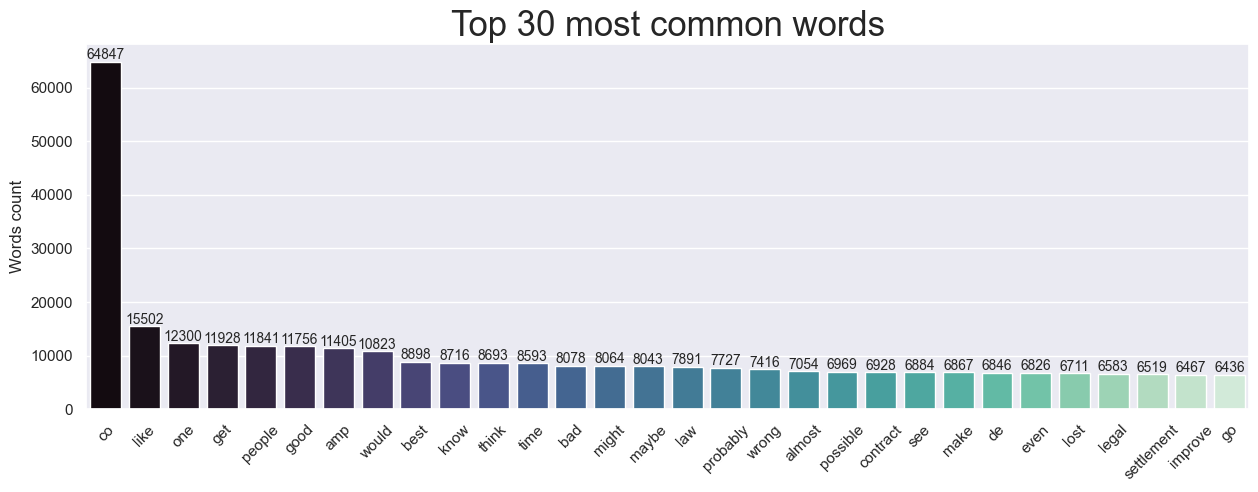

In [11]:
def most_used_words(n_words):
    text = ''.join(data['Text'].values)
    
    words = text.split()
    
    #Remove punctuation
    punc = list(punctuation)
    words = [word for word in words if word not in punctuation]
    
    #Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    word_count = Counter(words)
    
    top_words = word_count.most_common(n_words)
    
    return top_words

top_words = most_used_words(30)
xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(15,5))
ax = sns.barplot(x=xaxis, y=yaxis, palette='mako')
plt.title('Top 30 most common words', size = 25)

#Adding value on top of each bar
for i, count in enumerate(yaxis):
    plt.text(i, count + 500, str(count), ha='center', fontsize=10)


plt.ylabel('Words count')
plt.xticks(rotation = 45)
plt.subplots_adjust(bottom = 0.15)
plt.show()

# Data Preprocessing

## Encoding

In [76]:
labels = lb.fit_transform(data['Label'].values)
np.unique(labels)

array([0, 1, 2, 3])

## Text Preprocessing

In [13]:
def process_text(text):
    # Initialize tools    
    LEMMATIZER = WordNetLemmatizer()
    STOP_WORDS = stopwords.words('english')
    PUNCTUATION = string.punctuation

    
    # Tokenization, stopword removal, stemming, and lemmatization
    words = word_tokenize(text)
    words = [word for word in words if word not in PUNCTUATION and word not in STOP_WORDS and word.isalpha()]
    words = [LEMMATIZER.lemmatize(word) for word in words]
    
    return ' '.join(words)
data['Text'] = data['Text'].apply(process_text)
data

Text        Label  \
0       charlie corley kristineg amyklobuchar stylewri...    litigious   
1       badbunny como do gotas de agua joven se disfra...     negative   
2       co yjniopjv flagstar bank discloses data breac...    litigious   
3       rwanda set host headquarters united nation dev...     positive   
4       oops typed name incorrectly today brave witnes...    litigious   
...                                                   ...          ...   
199995  jbenton probably conservative many topic journ...  uncertainty   
199996  ok either someone involved mesa verda settleme...    litigious   
199997         lashaniede fertilizing egg regularly dream     positive   
199998  fbi warns asian business owner new jersey soph...    litigious   
199999           bbqdrip mikepapaswan bro emoted accident     negative   

        tweet_len  
0              22  
1              19  
2              13  
3              25  
4              27  
...           ...  
199995         39  
199996         43  
199997          9  
199998         17  
199999          6  

[191083 rows x 3 columns]

## WordCloud

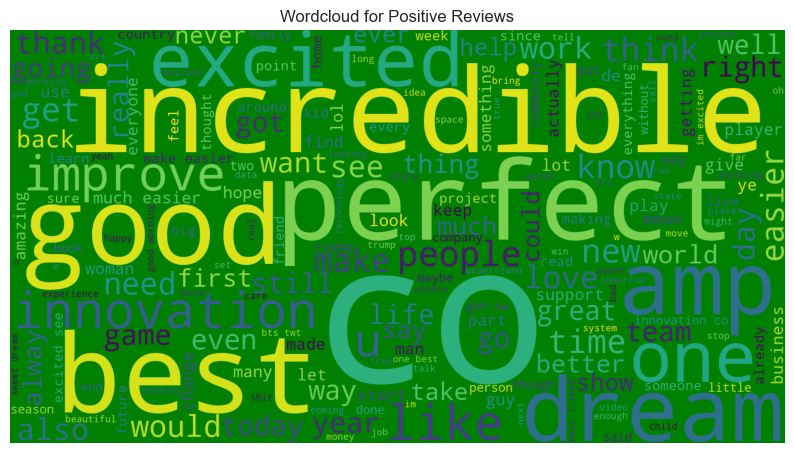

In [14]:
positive_reviews = data[data['Label'] == 'positive']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='green',
                          stopwords=stopwords.words('english'),
                          min_font_size = 15).generate(pos)
plt.figure(figsize = (10, 10))
plt.imshow(pos_wordcloud)
plt.title('Wordcloud for Positive Reviews')
plt.axis('off')
plt.show()

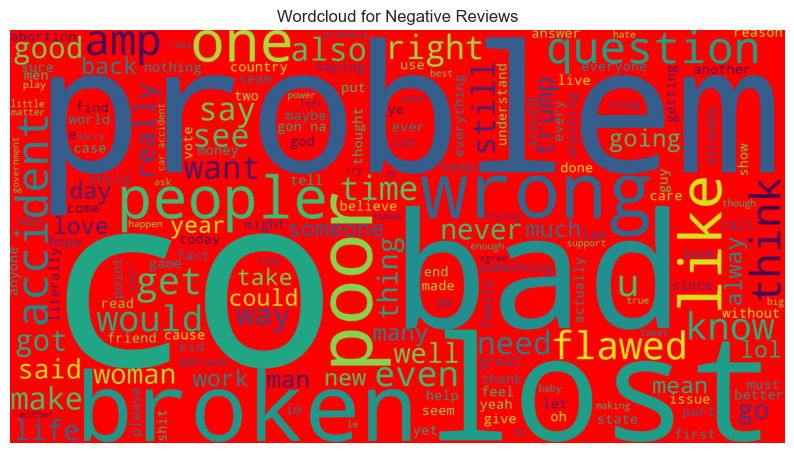

In [15]:
positive_reviews = data[data['Label'] == 'negative']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='red',
                          stopwords=stopwords.words('english'),
                          min_font_size = 15).generate(pos)
plt.figure(figsize = (10, 10))
plt.imshow(pos_wordcloud)
plt.title('Wordcloud for Negative Reviews')
plt.axis('off')
plt.show()

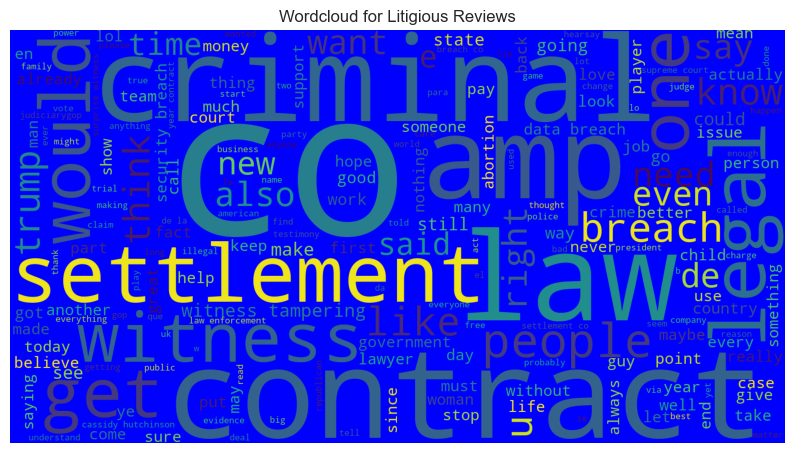

In [16]:
positive_reviews = data[data['Label'] == 'litigious']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='blue',
                          stopwords=stopwords.words('english'),
                          min_font_size = 15).generate(pos)
plt.figure(figsize = (10, 10))
plt.imshow(pos_wordcloud)
plt.title('Wordcloud for Litigious Reviews')
plt.axis('off')
plt.show()

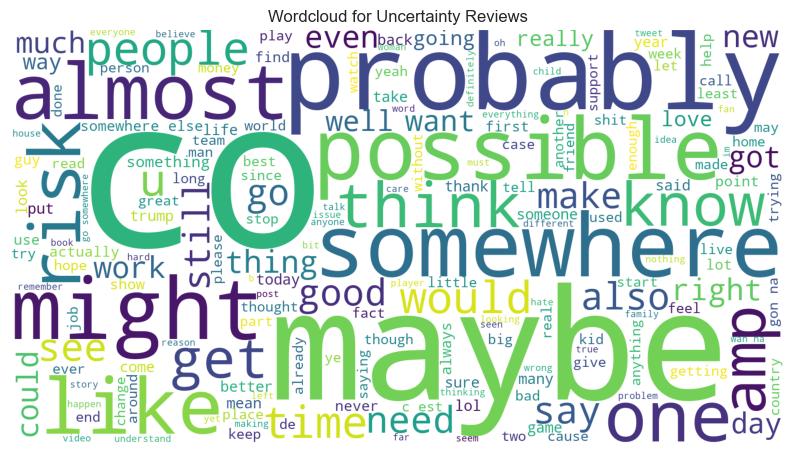

In [17]:
positive_reviews = data[data['Label'] == 'uncertainty']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='white',
                          stopwords=stopwords.words('english'),
                          min_font_size = 15).generate(pos)
plt.figure(figsize = (10, 10))
plt.imshow(pos_wordcloud)
plt.title('Wordcloud for Uncertainty Reviews')
plt.axis('off')
plt.show()

## Feature Extraction

In [18]:
vec = TfidfVectorizer(strip_accents='ascii', analyzer = 'word',
                      smooth_idf=True, norm = None, min_df=10)
vec.fit(data['Text'])
print(f'No of feature words: ', len(vec.get_feature_names_out()))

No of feature words:  18206


In [19]:
Features = vec.fit_transform(data['Text']).toarray()

In [20]:
print('The shape of the dataset: ', Features.shape)
print('Some of the vocabulary: ', list(vec.vocabulary_.items())[:10])

The shape of the dataset:  (191083, 18206)
Some of the vocabulary:  [('charlie', 2579), ('amyklobuchar', 619), ('testimony', 16166), ('evidence', 5514), ('court', 3515), ('law', 9083), ('state', 15403), ('federal', 5862), ('must', 10619), ('stand', 15369)]


# Modeling and Training

## Text to Vector Transformation

In [26]:
def Vectorizer(col, MAXLEN = 60):
    sents = data[col].tolist()
    
    # build vocabulary
    corpus = [word for text in data[col] for word in text.split()]
    vocab_size = len(Counter(corpus))
    
    tokenizer = Tokenizer(num_words=vocab_size , oov_token = "<OOV>" , 
                          filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'
                         )
    
    tokenizer.fit_on_texts(sents)
    
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    
    #Text Vectorization
    seqs = tokenizer.texts_to_sequences(sents)
    
    pad_seqs = pad_sequences(seqs, maxlen=MAXLEN, padding = 'post')
    
    return pad_seqs, tokenizer

seqs, tokenizer = Vectorizer('Text')

In [29]:
seq_sent = ' '.join([tokenizer.index_word[idx] for idx in seqs[10] if idx != 0])  
print(f"{seqs[10]} \n\n {seq_sent}")

[80134 80135 12876   299    55   748   459    76  4269     7  9421     9
   299  5929     8  1113   606   134     6   818   112  1357     8   630
   151   369   292  1046   292 11559  9955   204     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0] 

 jacobringenwald akeithwatts countdankulatv agree flawed response small many pl people presume would agree nuance amp understanding needed case good starting point drink amp drive play gun sound advice sound simplistic nevertheless true


In [33]:
# Define parameters
VOCAB_SIZE = len(tokenizer.word_index)
EMBEDDING_DIM = 256
MAXLEN = np.max(data['tweet_len'])

## Word2Vec

In [37]:
Word2vec_train_data = list(map(lambda x:x.split() , data['Text'].tolist()))
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)
print('Vocabulary Length: ', len(word2vec_model.wv.key_to_index))

Vocabulary Length:  31674


In [41]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print(f'Embedding Matrix Shape: {embedding_matrix.shape}')

Embedding Matrix Shape: (319613, 256)


## OneHotEncoding

In [43]:
seqs_labels = tf.keras.utils.to_categorical(labels , len(np.unique(labels)))
print(f'Shape before one-hot encoding : {labels.shape}')
print(f'Shape after one-hot encoding : {seqs_labels.shape}')

Shape before one-hot encoding : (191083,)
Shape after one-hot encoding : (191083, 4)


## Splitting Data

In [45]:
X_train, X_val, y_train, y_val = train_test_split(seqs, seqs_labels, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=0)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((152866, 60), (19108, 60), (19109, 60), (152866, 4), (19108, 4), (19109, 4))

## Data Pipeline

In [46]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000

In [51]:
# Training
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Validation
val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_set = val_set.batch(BATCH_SIZE, drop_remainder=True)

# Testing
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.batch(BATCH_SIZE)

print(f'The size of training dataset: {len(train_set)} batches of {BATCH_SIZE}')
print(f'The size of validation dataset: {len(val_set)} batches of {BATCH_SIZE}')
print(f'The size of testing dataset: {len(test_set)} batches of {BATCH_SIZE}')

The size of training dataset: 1194 batches of 128
The size of validation dataset: 149 batches of 128
The size of testing dataset: 150 batches of 128


## Modeling

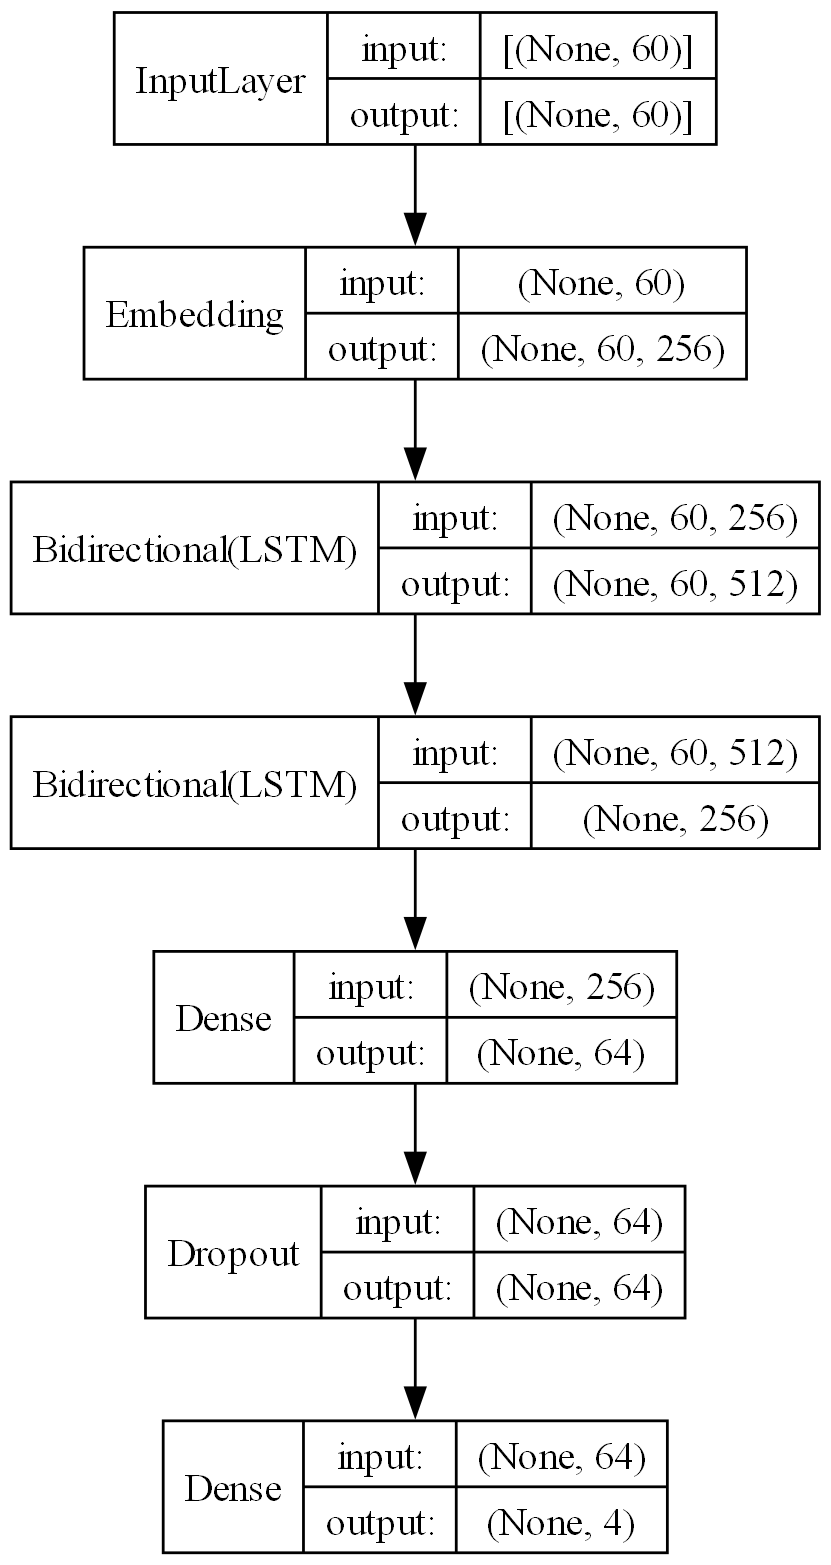

In [54]:
model = Sequential([
    Embedding(
        input_dim = VOCAB_SIZE , 
        output_dim= EMBEDDING_DIM , 
        weights = [embedding_matrix] , 
        input_length = MAXLEN ,
        trainable=False
    ) , 
    Bidirectional(LSTM(256 , return_sequences=True)) , 
    Bidirectional(LSTM(128)) , 
    Dense(64 , activation='relu') , 
    Dropout(0.5) , 
    Dense(4 , activation='softmax')
])
plot_model(model, show_shapes=True, show_layer_names=False, dpi = 200)

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 60, 256)           81820928  
                                                                 
 bidirectional_2 (Bidirectio  (None, 60, 512)          1050624   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                

## Model Checkpoint

In [61]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

# Early Stopping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLRonPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6)

# Training

In [62]:
model.compile(optimizer = Adam(learning_rate=0.001),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

history = model.fit(
    train_set,
    epochs = 50,
    batch_size = BATCH_SIZE,
    validation_data = val_set,
    callbacks = [checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/50
1194/1194 [==============================] - 60s 43ms/step - loss: 0.1092 - accuracy: 0.9600 - precision: 0.9683 - recall: 0.9525 - val_loss: 0.0706 - val_accuracy: 0.9696 - val_precision: 0.9731 - val_recall: 0.9674 - lr: 0.0010
Epoch 2/50
1194/1194 [==============================] - 54s 45ms/step - loss: 0.0699 - accuracy: 0.9710 - precision: 0.9755 - recall: 0.9675 - val_loss: 0.0636 - val_accuracy: 0.9726 - val_precision: 0.9767 - val_recall: 0.9693 - lr: 0.0010
Epoch 3/50
1194/1194 [==============================] - 47s 39ms/step - loss: 0.0656 - accuracy: 0.9730 - precision: 0.9774 - recall: 0.9697 - val_loss: 0.0665 - val_accuracy: 0.9727 - val_precision: 0.9753 - val_recall: 0.9709 - lr: 0.0010
Epoch 4/50
1194/1194 [==============================] - 47s 39ms/step - loss: 0.0630 - accuracy: 0.9743 - precision: 0.9785 - recall: 0.9711 - val_loss: 0.0653 - val_accuracy: 0.9734 - val_precision: 0.9772 - val_recall: 0.9704 - lr: 0.0010
Epoch 5/50
1194/1194 [==============

# Evaluation

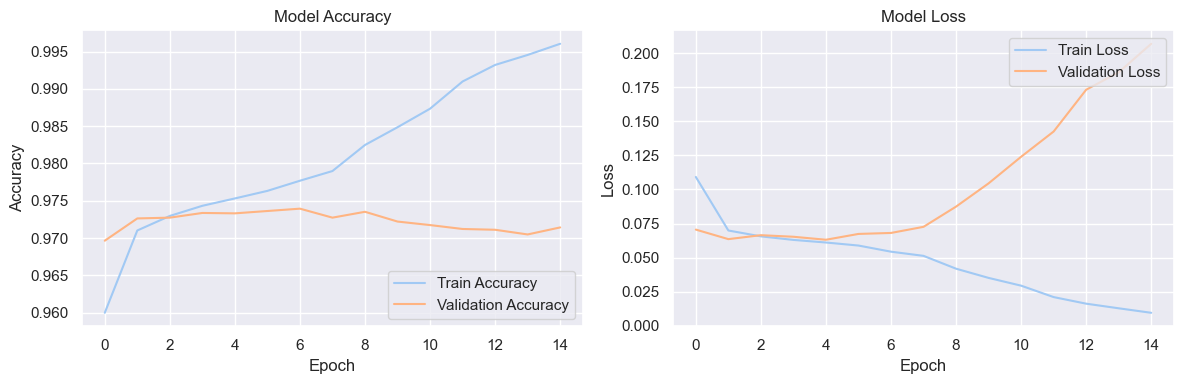

In [68]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()

In [69]:
model.save('SentimentAnalysis.h5')

150/150 [==============================] - 3s 17ms/step


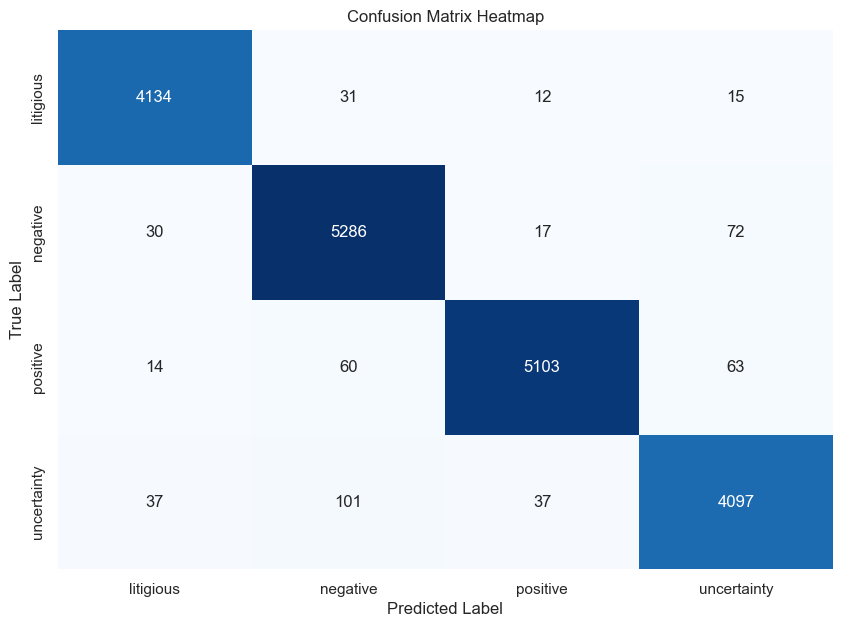

In [81]:
preditions =  model.predict(test_set)
y_pred = np.argmax(preditions, axis = 1)
y_true = np.argmax(y_test, axis = 1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

class_names = lb.classes_
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [79]:

class_name

array(['litigious', 'negative', 'positive', 'uncertainty'], dtype=object)